# Historical Trends and Bias in Classical Music Competitions

<center><img width=600 height=300 src="http://europe.yamaha.com/en/news_events/artists/chopin_piano_competition_16/images/chopin_piano_competition_yulianna.jpg"/></center>
<p>
While winning a major music competitions has historically been one of the most popular ways for young musicians to make a career in performance, the nature of the competitions is widely believed to be subjective and unfair (see for example https://hearhereatnec.wordpress.com/2013/04/27/listening-with-your-ears-asian-musicians-and-racial-discrimination/ and http://www.theguardian.com/women-in-leadership/2013/oct/14/blind-auditions-orchestras-gender-bias). In particular, it is often said in musical circles that competitions favor white men while being biased against women and non-European contestants (particularly those from Asian contries):
<p>
<center><i>"...There is an (often unspoken) criticism that the majority of Asian/Korean pianists are all technique and no musicality, pianistic robots."</i><br>
James Rhodes (music critic, London Telegraph)</center>
<p>
To the best of our knowledge, this perceived bias has never been quantified. Here we explore historical trends and bias in major music competitions. We study trends in how gender and national origin plays a role in winning competitions and how these trends have changed over time.

In [53]:
# import standard libraries for later use
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# below we will use BeautifulSoup to parse HTML code. We will also use the requests module to pull data
from bs4 import BeautifulSoup
import requests

# I. Data Munging:
We begin by scraping the web for data on competition winners. We consider the following competitions, widely considered to be among the most prestigious in the world:
- International Chopin Piano Competition
- Cleveland International Piano Competition
- International Tchaikovsky Competition (piano, violin, cello)
- Leeds International Piano Competition 
- Valencia International Piano Competition
- International Violin Competition of Indianapolis
- Queen Elizabeth Competition (piano, violin)
- Henryk Wieniawski Violin Competition

In [54]:
# In this cell we use the requests module to pull data for varioua competitions from the internet
Chopin = requests.get("https://en.wikipedia.org/wiki/International_Chopin_Piano_Competition")
Cleveland = requests.get("https://en.wikipedia.org/wiki/Cleveland_International_Piano_Competition")
Tchaikovsky = requests.get("https://en.wikipedia.org/wiki/International_Tchaikovsky_Competition")
Leeds = requests.get("https://en.wikipedia.org/wiki/Leeds_International_Piano_Competition")
Iturbi = requests.get("https://en.wikipedia.org/wiki/Valencia_International_Piano_Competition_Prize_Iturbi")
Indianapolis = requests.get("https://en.wikipedia.org/wiki/International_Violin_Competition_of_Indianapolis")
QueenElizabeth = requests.get("https://en.wikipedia.org/wiki/Queen_Elisabeth_Competition")
Wieniawski = requests.get("https://en.wikipedia.org/wiki/Henryk_Wieniawski_Violin_Competition")

Unofortunately, the data tables on Wikipedia are not standardized (like in the Billboard 100 example we did in the homework). Therefore, the data has to be formatted individually for each competition. We do this below. In the end, we can combine the results of all competitions into a single list.

Because gender information is not available, we put it in by hand (all prizewinners of these competitions are famous enough that their gender - if not obvious - can be readily found online).

We create a function analyze_table to parse the html data (using Beautiful Soup). This standardized function is used to parse and analyze data for only some of the competitions. For pages with significantly different formatting, the analysis has to be done on a page-by-page basis. The procedure for scraping the data is similar in spirit for each different page even if the details vary. Therefore, in the interest of keeping the code less cluttered, we will only comment extensively the function analyze_table. The rest are treated in an analogous way.

In [55]:
def analyze_table(requesttext,tablenum,compname,instr):
    soup = BeautifulSoup(requesttext.text, "html.parser") # use BeautifulSoup to parse HTML code
    tables = soup.find_all("table", attrs={"class": "wikitable"}) # find tables

    rows = tables[tablenum].find_all("tr")[1:] # use rows 1 and on from the table 

    contestantinfo = [] # initialize variable to hold contestant info
    for row in rows: # loop over all items in the table rows
        cols = row.find_all("td")
        prizenum = 1; # since prize #1 is always on left, start with 1 and increase value with each iteration
        for col in cols: # loop over all columns
            flags = col.find_all("span", attrs={"class": "flagicon"}) # find all countries that are represented in each cell
            numflags = len(flags) # number of countries
            coltext = col.get_text() # get the text of table cell
            if numflags > 0: # only analyze data where some country is represented (no country means prize not awarded)
                try: # check for error
                    year = row.find("th").get_text() # first column has year of competition
                    year = year[:4] # choose the first 4 characters, since there is other info in this field
                    
                    # initialize variables to hold names and countries
                    name = []
                    country = []
                    
                    # first iterate through all represented countries and get country names
                    for i in range(numflags):
                        country.append(flags[i].find("a").get("title"))
                    
                    # now iterate through all represented countries again and get the unique names.
                    # This loop canont be combined with the loop above since there are sometimes more than one
                    # country for a contestant (e. g. joint citizenship)
                    exitflag = 0
                    for i in range(numflags):
                        if (coltext.find("\n") == -1) & (exitflag == 0): # when find cannot locate \n (newline) it returns -1
                            name.append(coltext)
                            exitflag = 1
                        elif (coltext.find("\n") != -1) & (exitflag == 0):
                            name.append(coltext[coltext.find(""):coltext.find("\n")])
                            coltext = coltext[coltext.find("\n")+1:]
                        
                    # for each unique name append a different row to the contestant info list.
                    # in the case of joint citizenship, leave countries represented as list
                    for i in range(len(name)):
                        if len(name) < len(country):
                            contestantinfo.append([name[i], compname, country, year, instr, prizenum])
                        else:
                            contestantinfo.append([name[i], compname, country[i], year, instr, prizenum])
                except: # if error found, do not append new entry to contestant info list
                    dummy = 0
            prizenum = prizenum + 1 # increase prize number for next iteration
    return contestantinfo

In [56]:
# Cleveland International Piano Competition
contestantinfo1 = analyze_table(Cleveland,0,'Cleveland','piano')
contestantinfo2 = analyze_table(Cleveland,1,'Cleveland','piano')
contestantinfo = contestantinfo1 + contestantinfo2 # since data is in two tables, concatenate together

# since gender information is not available as part of the wikipedia tables, we have to put it in by hand        
gender = ['m','m','m','m','m','m','m','f','f','m','m','m','m','m','m','m','f','m','m','m',
         'm','f','m','m','m','m','m','m','m','m','f','m','m','f','m','m','f','f','m','m','m','m',
         'f','m','m','m','m','m','m','f','m','m','f','m','m','f','m','m','m','f','m','f',
         'm','m','f','m','m','m','f','f','m','m','m','f','m','m','m','m','m','m','m','m','f',
         'm','m','m','f','m','m','f','m','f','m','m','m','m','f','m']

# add gender information to table
for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])
    
Data_Cleveland = contestantinfo # store data in separate variable for later use

In [57]:
# Leeds International Piano Competition
contestantinfo = analyze_table(Leeds,0,'Leeds','piano')

# exceptions: weird formatting for only 3 fields - fix by hand
contestantinfo[80][0] = u' Andras Schiff'
contestantinfo[81][0] = u' Pascal Devoyon'
contestantinfo[82][0] = u' Michael Houston'
contestantinfo[83][0] = u' Myung-whun Chung'
contestantinfo[93][0] = u' Viktoria Postnikova'
contestantinfo[94][0] = u' Semyon Kruchin'

gender = ['f','f','m','m','m','f','m','m','m','m','m','m','f','m','m','m','f','m','m','m','m','m',
         'm','f','m','f','f','m','f','m','m','m','m','m','f','f','m','m','m','f','m','f',
         'm','m','m','m','m','f','m','m','m','m','f','m','m','m','f','m','m','m','m','f','f','m','m','f',
         'm','m','m','m','m','m','m','f','f','m','f','f','m','f','m','m','m','m','m','m','m','m','m','m','m',
         'f','m','f','m','m','m','m','m','m','f']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])
    
Data_Leeds = contestantinfo

In [58]:
# Iturbi International Piano Competition
contestantinfo = analyze_table(Iturbi,1,'Iturbi','piano')

gender = ['f','m','m','m','m','m','f','m','f','f','f','m','m','m','m','f','f','m','f','f','f','f',
         'm','m','m','f','f','m','f','m','m','m','m','f','m','m','f','f','m','f','m']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])

Data_Iturbi = contestantinfo

In [59]:
# Indianapolis International Violin Competition
contestantinfo = analyze_table(Indianapolis,0,'Indianapolis','violin')
        
gender = ['f','f','f','f','f','f','f','f','m','m','m','m','m','f','f','f','f','f','m',
         'm','m','m','f','f','f','m','f','m','m','f','f','m','m','m','f','f','m','m','m','f',
         'm','m','f','m','m','m','m','f','f','f','m','m','m','f']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])

Data_Indianapolis = contestantinfo

In [60]:
# Queen Elizabeth International Competition
contestantinfo_violin = analyze_table(QueenElizabeth,6,'Queen Elizabeth','violin')
contestantinfo_piano = analyze_table(QueenElizabeth,7,'Queen Elizabeth','piano')

contestantinfo = contestantinfo_violin + contestantinfo_piano
        
gender = ['m','m','f','m','f','m','m','m','m','m','m','m','f','m','m','m','m','m','m','m','m',
         'm','m','m','m','f','m','m','m','f','m','m','f','f','m','f','m','m','f','f','m',
         'm','f','f','m','m','m','m','f','m','f','m','m','f','f','m','m','m','f','m','m','m','m',
         'f','f','f','m','f','m','m','m','f','f','m','m','m','m','f','m','m','m','f','f',
         'm','f','m','m','m','m','m','f','m','m','f','m','m','f','m','m','m','m','m','f','m',
         'm','m','m','f','m','m','m','m','m','m','f','m','m','m','m','m','m','m','m','f','m','m','m',
         'm','m','m','m','f','m','m','m','m','m','m','f','m','f','m','m','f','m','m','m','f','m',
         'm','f','m','f','m','m','m','m','m','m','m','m','m','m','f','f','m','m','f','m',
         'm','m','m','m','m','m','m','m','f']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])
    
Data_QueenElizabeth = contestantinfo

The last three competitions have sufficiently different format, so they need to be analyzed separately.

In [61]:
# Chopin International Piano Competition
soup = BeautifulSoup(Chopin.text, "html.parser") 
tables = soup.find_all("table", attrs={"class": "wikitable"}) 

rows = tables[0].find_all("tr")[1:] 

contestantinfo = [] 
for row in rows: 
    cols = row.find_all("td") 
    
    prizenum = 1; 
    for col in cols: 
        flags = col.find_all("span", attrs={"class": "flagicon"}) 
        numflags = len(flags) 
        coltext = col.get_text() 

        if numflags > 0: 
            year = row.find("th").get_text() 
            year = year[-4:] 
            
            name = []
            country = []
            
            for i in range(numflags):
                country.append(flags[i].find("a").get("title"))
            
            exitflag = 0
            for i in range(numflags):
                if (coltext.find("\n") == -1) & (exitflag == 0): 
                    name.append(coltext)
                    exitflag = 1
                elif (coltext.find("\n") != -1) & (exitflag == 0):
                    name.append(coltext[coltext.find(""):coltext.find("\n")])
                    coltext = coltext[coltext.find("\n")+1:]
            
            for i in range(len(name)):
                if len(name) < len(country):
                    contestantinfo.append([name[i], 'Chopin', country, year, "piano", prizenum])
                else:
                    contestantinfo.append([name[i], 'Chopin', country[i], year, "piano", prizenum])
                    
        prizenum = prizenum + 1 

gender = ['m','m','f','m','m','m','m','m','m','m','m','f','m','m','f','f','f','f','f','m','m',
         'm','m','m','m','m','m','m','m','m','f','f','m','f','m','f','m','f','f','m','f','m','f','m',
         'm','f','m','m','f','f','m','m','f','m','f','m','f','f','m','f','m','m','m','f','m',
         'f','m','m','m','f','f','f','f','m','m','f','m','f','f','m','f','m','f','m','f','m',
         'm','m','m','m','f','f','m','m','m','m','m','m','m','f','m','m','m']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])

Data_Chopin = contestantinfo 

In [62]:
# Tchaikovsky International Competition (piano, voilin, cello)
soup = BeautifulSoup(Tchaikovsky.text, "html.parser")
tables = soup.find_all("table", attrs={"class": "wikitable"})

# piano competition
rows = tables[1].find_all("tr")[1:]

contestantinfo = []
for row in rows:
    cols = row.find_all("td")[1:]
    prizenum = 1;
    for col in cols:
        winners = len(col.find_all("a"))
        coltext = col.get_text()
        year = row.find("td").get_text()
        year = year[0:4]
        if not coltext:
            country = "None"
            name = "None"
        else:
            name = []
            country = []
            for i in range(winners):
                name.append(coltext[coltext.find(""):coltext.find("(")-1])
                coltext = coltext[coltext.find("("):]
                country.append(coltext[coltext.find("(")+1:coltext.find(")")])
                coltext = coltext[coltext.find("\n")+1:]
        contestantinfo.append([name, 'Tchaikovsky', country, year, "piano", prizenum])
        prizenum = prizenum + 1

# violin competition
rows = tables[2].find_all("tr")[1:]

for row in rows:
    cols = row.find_all("td")[1:]
    prizenum = 1;
    for col in cols:
        winners = len(col.find_all("a"))
        coltext = col.get_text()
        year = row.find("td").get_text()
        year = year[0:4]
        if not coltext:
            country = "None"
            name = "None"
        else:
            name = []
            country = []
            for i in range(winners):
                name.append(coltext[coltext.find(""):coltext.find("(")-1])
                coltext = coltext[coltext.find("("):]
                country.append(coltext[coltext.find("(")+1:coltext.find(")")])
                coltext = coltext[coltext.find("\n")+1:]
        contestantinfo.append([name, 'Tchaikovsky', country, year, "violin", prizenum])
        prizenum = prizenum + 1

# cello competition
rows = tables[3].find_all("tr")[1:]

for row in rows:
    cols = row.find_all("td")[1:]
    prizenum = 1;
    for col in cols:
        winners = len(col.find_all("a"))
        coltext = col.get_text()
        year = row.find("td").get_text()
        year = year[0:4]
        if not coltext:
            country = "None"
            name = "None"
        else:
            name = []
            country = []
            for i in range(winners):
                name.append(coltext[coltext.find(""):coltext.find("(")-1])
                coltext = coltext[coltext.find("("):]
                country.append(coltext[coltext.find("(")+1:coltext.find(")")])
                coltext = coltext[coltext.find("\n")+1:]
        contestantinfo.append([name, 'Tchaikovsky', country, year, "cello", prizenum])
        prizenum = prizenum + 1

for item in contestantinfo:
    if len(item[2]) == 1:
        item[2] = item[2][0]
    if len(item[0]) > 1:
        for i in range(len(item[0])):
            contestantinfo.append([[item[0][i]], item[1], item[2][i], item[3], item[4], item[5]])

for item in sorted(contestantinfo, reverse=True):    
    if len(item[0]) == 0:
        contestantinfo.pop(contestantinfo.index(item))
    elif len(item[0]) > 1:
        contestantinfo.pop(contestantinfo.index(item))

for item in contestantinfo:
    item[0] = item[0][0]
        
gender = ['m','m','f','m','m','m','m','m','m','m','f','m','f','f','m','m','m','m','m','m',
         'f','m','m','m','m','f','m','m','m','m','m','m','m','m','f','f','f','f','m',
         'f','m','f','f','f','m','f','m','f','f','m','f','f','m','f','m','m','m',
         'm','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m','m',
         'm','m','f','m','m','m','m','f','m','m','m','m','m','m','m','m','m','m','m','m','f',
         'm','m','m','m','m','m','m','f','f','f','f','m','f','m','m','f','m','m','m','f','m','m','m','f',
         'f','f','m','f','m','f','m','m','m','m','m','f','f','m','m','m','m','f','m','m',
         'm','m','f','m','m','m','m','f','f','m','m','m','m','m','m','m','f','m','f','m','m','m','m','m']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])
    
Data_Tchaikovsky = contestantinfo

In [63]:
# Wieniawski Violin Competition
soup = BeautifulSoup(Wieniawski.text, "html.parser")
tables = soup.find_all("table", attrs={"class": "wikitable"})

rows = tables[0].find_all("tr")[1:]

contestantinfo = []
for row in rows:
    cols = row.find_all("td")
    prizenum = 1;
    for k in range(len(cols)/2):
        flags = cols[2*k+1].find_all("span", attrs={"class": "flagicon"})
        numflags = len(flags)
        coltext = cols[k].get_text()
        col = cols[2*k]
        if numflags > 0:
            year = row.find("th").get_text()
            year = year[-4:]
            name = []
            country = []
            country_entries = cols[2*k+1].find_all("a")
            name_entries = cols[2*k].find_all("a")
            for i in range(numflags):
                country.append(country_entries[i].get("title"))
            exitflag = 0
            for i in range(numflags):
                name.append(name_entries[i].get("title"))
            for i in range(len(name)):
                if len(name) < len(country):
                    contestantinfo.append([name[i], 'Wieniawski', country, year, "violin", prizenum])
                else:
                    contestantinfo.append([name[i], 'Wieniawski', country[i], year, "violin", prizenum])
        prizenum = prizenum + 1    
        
gender = ['f','m','m','m','m','f','f','f','f','f','m','m','m','m','m','m','m','f','f','f','f',
         'm','m','m','m','m','f','f','m','m','f','m','m','m','f','f','f','f','m','f','f',
         'f','m','m','f','f','f','f','f','f','f','m']

for i in range(len(contestantinfo)):
    contestantinfo[i].append(gender[i])
    
Data_Wieniawski = contestantinfo

In [64]:
# concatenate data together
Data = Data_Chopin + Data_Cleveland + Data_Tchaikovsky + Data_Leeds + Data_Iturbi + Data_Indianapolis + Data_QueenElizabeth + Data_Wieniawski
print "Number of Entries: ", len(Data)

Number of Entries:  794


# II. Data Analysis: exploring historical trends
We begin our analysis by looking at historical trends as a function of gender and nationality. For simplicity, we group countries into four categories: Europe, Asia, USA/Canada, and Other. The Other category is largely made up from contestants of South American or Middle-Eastern origin. Due to the large number of countries represented and the relatively small sample size, dealing with all the individual countries will be too unwieldy. 

We first consider the unordered set of prizewinners (prize number is ignored) in each competition and look for visible patterns.

In [65]:
# Define categories: these were determined by converting the dataset into a dataframe and using the unique() function

USA_Canada = ["USA","United States","Canada","USA/Canada"]
Asia = ["Japan","South Korea","China","Taiwan","Vietnam","Hong Kong","Korea","Philippines","Singapore",["Taiwan","China"]]
Europe = ["Soviet Union","Russia","USSR","Poland","France","Germany","Italy","Hungary","United Kingdom","Denmark",
         "Lithuania","Bulgaria","Croatia","Switzerland","Sweden","Ukraine","Armenia","West Germany","UK","Romania",
         "Bielorussia","Lithuania/Russia","Moldova","Finland","Czechoslovakia","Luxemburg","Latvia","Socialist Federal Republic of Yugoslavia",
         "Portugal","Republic of Ireland","Spain","Netherlands","Iceland","Greece","Belgium",["Russia","Spain"],
         ["Ukraine","United Kingdom"],"Austria"]

# Filter data using the above categories
# Also, we create an indicator for the gender column. The value 1 will indicate female and the value 0
# will indicate male. We additionally convert the year to an integer.

for entry in Data:
    # group into regions
    if entry[2] in USA_Canada:
        entry[2] = "USA/Canada"
    elif entry[2] in Asia:
        entry[2] = "Asia"
    elif entry[2] in Europe:
        entry[2] = "Europe"
    else:
        entry[2] = "Other"
    
    # create indicator for gender
    if entry[6] == 'f':
        entry[6] = 1
    else:
        entry[6] = 0
    
    # convert year to integer
    entry[3] = int(entry[3]) # convert year to integer

In [66]:
# now we convert the data to a Pandas DataFrame
df = pd.DataFrame(Data,columns = ["Name","Competition","Region","Year","Instrument","Prize","Gender"])

# save data to csv file
df.to_csv('musiccompetitions_data.csv', sep=',', encoding='utf-8')
# note that since the names of the contestants are not used anywhere in the analysis, we don't worry about some of
# the formatting errors that occur after pulling the data from Wikipedia.

df.head()

,Name,Competition,Region,Year,Instrument,Prize,Gender
0,Lev Oborin,Chopin,Europe,1927,piano,1,0
1,Stanisław Szpinalski,Chopin,Europe,1927,piano,2,0
2,Róża Etkin,Chopin,Europe,1927,piano,3,1
3,Grigory Ginzburg,Chopin,Europe,1927,piano,4,0
4,Alexandre Uninsky (c),Chopin,Europe,1932,piano,1,0


Here we consider how the percentage of women who were among the winners of the competition has varied by year.

Average fraction of females:  0.312800981383


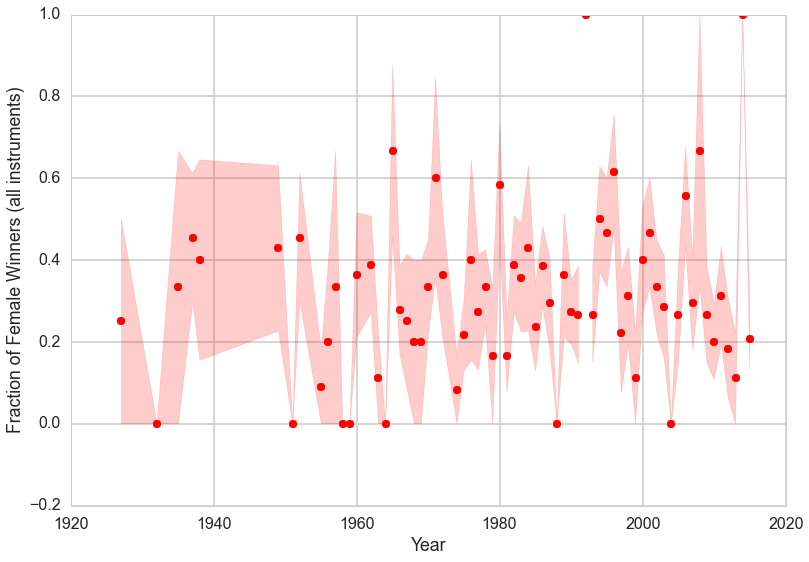

In [67]:
df_year = df.groupby('Year') # group dataframe by year
gender_prob = df_year['Gender'].mean() # get mean values of gender (amounts to fraction of females, since female=1, male=0)
gender_prob_standard_err = df_year['Gender'].std()/np.sqrt(df_year['Gender'].count()) # standard errors of mean
years = sorted(df_year.groups.keys()) # year values from groupby object

# using keys, get values and errors
female_prob = []
female_prob_err = []
for year in years:
    female_prob.append(gender_prob[year]) 
    female_prob_err.append(gender_prob_standard_err[year])

print "Average fraction of females: ", np.mean(female_prob)    

# plot fraction of female winners and 1-sigma error bands
plt.plot(years,female_prob,'o', markersize = 8, color = 'r')
plt.fill_between(years, np.array(female_prob) + np.array(female_prob_err), np.array(female_prob) - np.array(female_prob_err), color = 'r', alpha = 0.2)
plt.xlabel("Year")
plt.ylabel("Fraction of Female Winners (all instruments)")
plt.show()

Note that the error bars represent the standard error of the mean value (shown by red points), and not the standard deviation.

As we can see, it appears that music competitions are generally male-dominated with very few competitions having a fraction of 0.5 (expected by chance alone) or above of females. The mean fraction of females is approximately 0.3.

However, it appears that the story is much more interesting if we look at the trends on piano and violin separately (there is only one competition in the dataset for cello, so we ignore it for now).

Regression coefficient (violin):  0.00377981281419
Regression coefficient (piano):  0.000240427199096


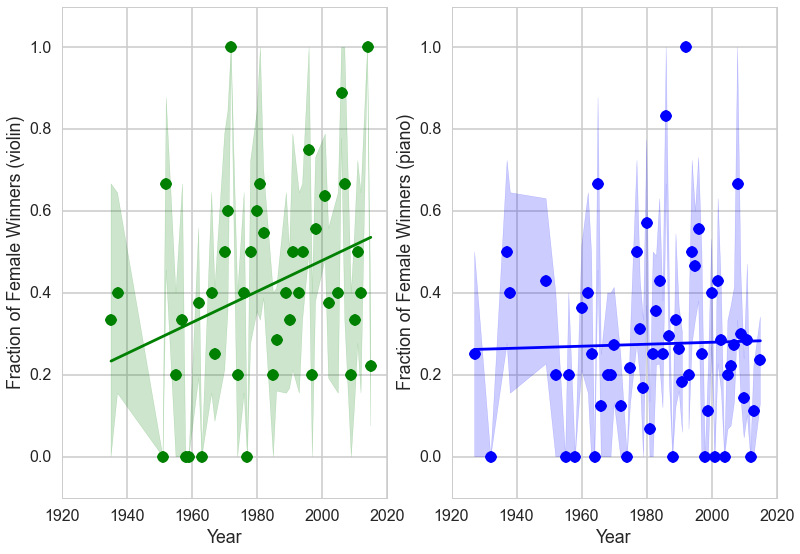

In [75]:
df_year_instr = df.groupby(['Instrument','Year']) # group dataframe by year and instruments
gender_prob = df_year_instr['Gender'].mean() # get mean values for gender column
gender_prob_standard_err = df_year_instr['Gender'].std()/np.sqrt(df_year_instr['Gender'].count()) # standard errors of mean
instr_year_keys = sorted(df_year_instr.groups.keys()) # year values from groupby object

# using keys, get values and errors
female_prob_violin = []
female_prob_violin_err = []
year_violin = []
female_prob_piano = []
female_prob_piano_err = []
year_piano = []
for key in instr_year_keys:
    if key[0] == 'violin':
        female_prob_violin.append(gender_prob[key])
        female_prob_violin_err.append(gender_prob_standard_err[key])
        year_violin.append(key[1])
    elif key[0] == 'piano':
        female_prob_piano.append(gender_prob[key])
        female_prob_piano_err.append(gender_prob_standard_err[key])
        year_piano.append(key[1])

# plot mean values and 1-sigma errors for violin (green) and piano(blue)
plt.subplot(1,2,1)
plt.plot(year_violin,female_prob_violin,'go')
plt.fill_between(year_violin, np.array(female_prob_violin) + np.array(female_prob_violin_err), np.array(female_prob_violin) - np.array(female_prob_violin_err), color = 'g', alpha = 0.2)
plt.xlabel("Year")
plt.ylabel("Fraction of Female Winners (violin)")

plt.subplot(1,2,2)
plt.plot(year_piano,female_prob_piano,'bo')
plt.fill_between(year_piano, np.array(female_prob_piano) + np.array(female_prob_piano_err), np.array(female_prob_piano) - np.array(female_prob_piano_err), color = 'b', alpha = 0.2)
plt.xlabel("Year")
plt.ylabel("Fraction of Female Winners (piano)")

# reshape arrays for linear regression
year_piano = np.reshape(year_piano,(len(year_piano),1))
female_prob_piano = np.reshape(female_prob_piano,(len(female_prob_piano),1))
year_violin = np.reshape(year_violin,(len(year_violin),1))
female_prob_violin = np.reshape(female_prob_violin,(len(female_prob_violin),1))

# perform linear regressions
from sklearn.linear_model import LinearRegression
lm1 = LinearRegression()
lm1.fit(year_violin, female_prob_violin)
print "Regression coefficient (violin): ", lm1.coef_[0][0]
lm2 = LinearRegression()
lm2.fit(year_piano, female_prob_piano)
print "Regression coefficient (piano): ", lm2.coef_[0][0]

# plot regression lines
plt.subplot(1,2,1)
plt.plot(year_violin,lm1.predict(year_violin),'g')
plt.xlim(1920,2020)  
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.plot(year_piano,lm2.predict(year_piano),'b')
plt.xlim(1920,2020)
plt.ylim(-0.1,1.1)
plt.show()

It appears that while the fraction of women winning piano competitions has been stuck at approximately 25-30% over the last century, the number of women winning violin competitions has gone up and is now roughly at the 50/50 chance level! Also, note that the regression lines are not plotted to make any predictions (since there was no training/test split performed) and the linear regression is not constrained to lie between 0 and 1. They are simply plotted as a visual aid to demonstrate the general trend. 

Let's now explore how people of various national origin do in competitions (violin and piano separately).

In [17]:
df_grouped_reg = df.groupby(['Instrument','Year','Region']) # group dataframe by instrument, year and region
keys = df.groupby(['Instrument','Year']).groups.keys() 

prizecounts = df_grouped_reg['Prize'].count() # count number of prizewinners

reg = ['Asia','Europe','USA/Canada','Other'] # label regions

# create empty lists of lists for fraction of violin and piano winners
frac_violin = [[],[],[],[]] 
frac_piano = [[],[],[],[]]
year_violin = []
year_piano = []

# get values using keys
for key in keys:
    if key[0] == 'violin':
        for i in range(len(frac_violin)):
            try:
                frac_violin[i].append(float(prizecounts[key][reg[i]])/prizecounts[key].sum())
            except:
                frac_violin[i].append(0)
        year_violin.append(key[1])
    elif key[0] == 'piano':
        for i in range(len(frac_piano)):
            try:
                frac_piano[i].append(float(prizecounts[key][reg[i]])/prizecounts[key].sum())
            except:
                frac_piano[i].append(0)
        year_piano.append(key[1])

First let's plot the trends for violin competitions:

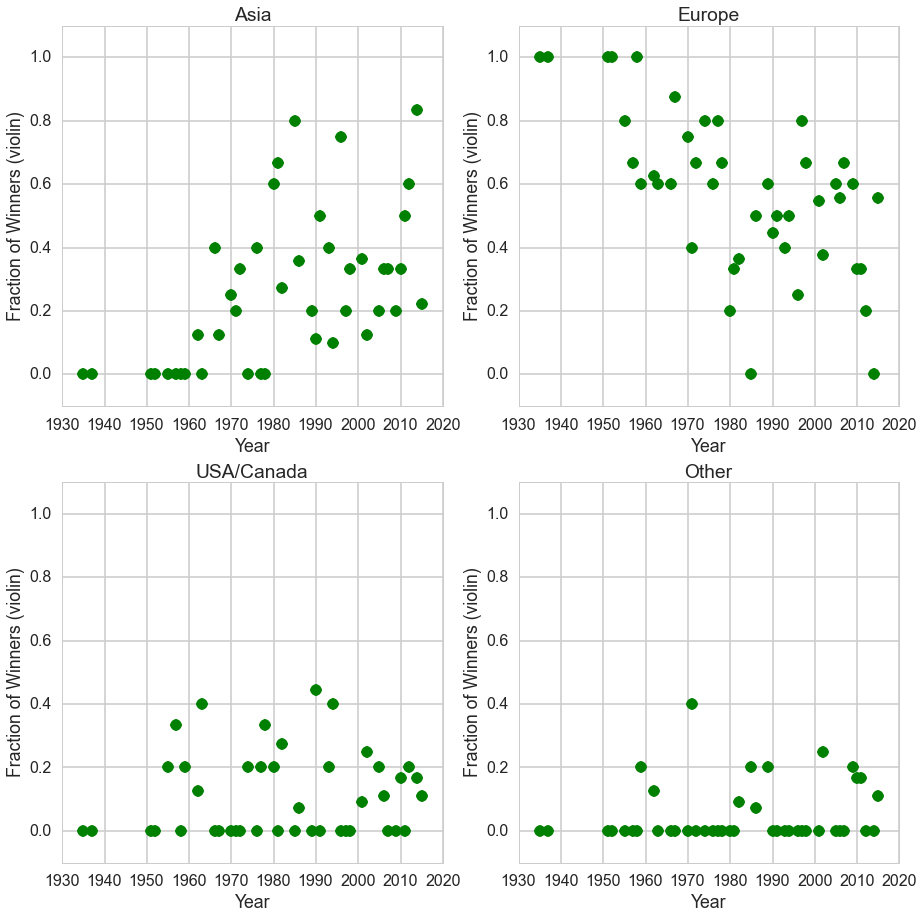

In [39]:
cnt = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), tight_layout = False) # make a 2x2 grid of subplots
for ax in axes.ravel():
    ax.plot(year_violin,frac_violin[cnt],'go')
    ax.set_ylim([-0.1, 1.1])
    ax.set_title(reg[cnt])
    ax.set_xlabel('Year')
    ax.set_ylabel('Fraction of Winners (violin)')
    cnt = cnt+1

And now for piano:

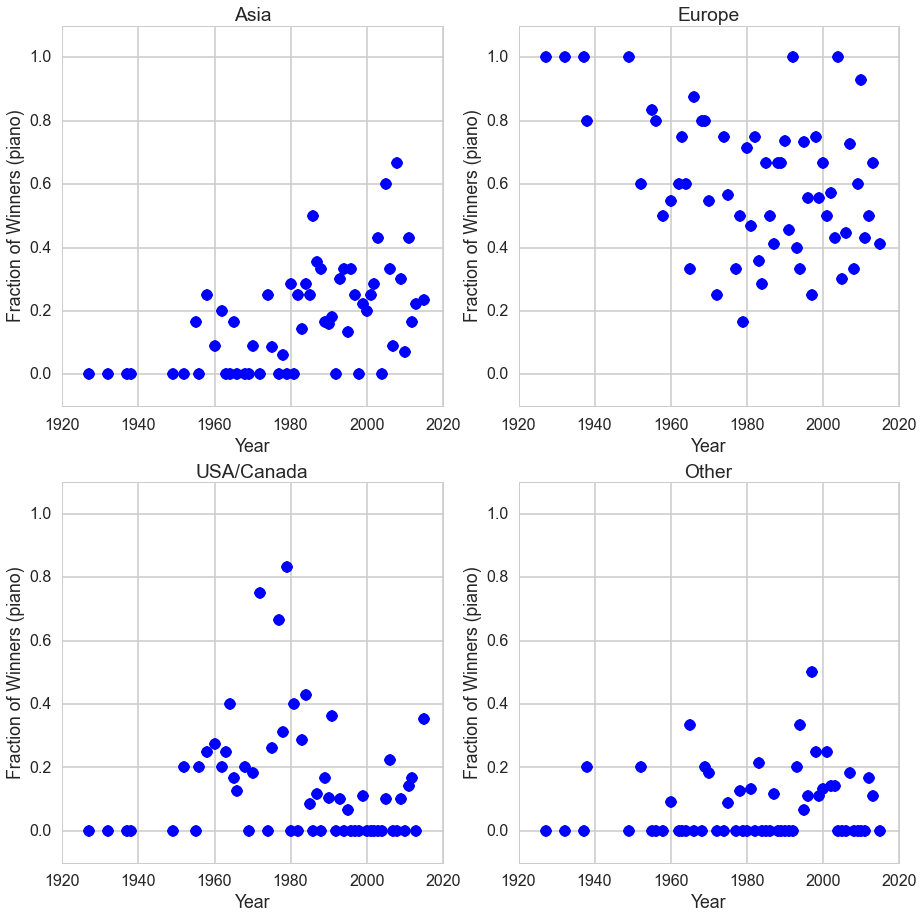

In [40]:
cnt = 0
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), tight_layout = False) # make a 2x2 grid of subplots
for ax in axes.ravel():
    ax.plot(year_piano,frac_piano[cnt],'bo')
    ax.set_ylim([-0.1, 1.1])
    ax.set_title(reg[cnt])
    ax.set_xlabel('Year')
    ax.set_ylabel('Fraction of Winners (piano)')
    cnt = cnt+1

From these two sets of plots, it is clear that there have been major trends in both violin and piano competitions. In both categories, starting in 1950's, the number of Asian winners has increased tremendously while, the corresponding number of European winners has gone down. Winners from USA/Canada and the Others categories have not shown such clear trends and have stayed more constant.

# III. Data Analysis: uncovering bias
While the plots above are certainly suggestive of an underlying trend, we cannot make any statements about potential bias. The reason is that there are many scenarios that can explain the observed trends. For example is the increase in female violinist winners due to a reduction in bias or just simply the result of more women entering violin competitions? We now see if we can account for these confounding effects and make some statements about underlying bias.

Up to now, we have considered the list of prizewinners of each competition as an unordered set. We now explore how gender and national origin affect a candidate's chances of winning a competition. We modify our data to group the prizewinners of each competition into two categories: those who won the top prize, and those who did not. The reason for this is that we can use the list of prizewinners as a proxy for the population breakdown of the competition (how many men/women, how many Asians, how many Europeans, etc took part in the competition). Since the data for the full list of competition entrants is almost never available, the reduced list of prizewinners is the best guess we can make at the real population breakdown.

The logic behind this is that if the trends evident in the plots above are simply due to more women and Asians entering competitions over the years, we expect the number of 1st prize winners from these groups to be at chance levels. If, however, the above trends are due to an underlying bias, we expect that contestants from these groups will get on average lower prizes.

We use logistic regression to classify contestants into those that won the top prize and those who did not. 

In [20]:
# Set up data for logistic regression
for item in Data:
    if item[5] != 1:
        item[5] = 0 # set all prizes other then #1 to 0
        
    # if instrument is piano, set instrument = 1, otherwise instrument = 0
    if item[4] == 'piano':
        item[4] = 1 
    else:
        item[4] = 0
        
# create dataframe based on these features
df = pd.DataFrame(Data, columns = ["Name","Competition","Region","Year","Instrument","Won","Gender"])
df.head()

,Name,Competition,Region,Year,Instrument,Won,Gender
0,Lev Oborin,Chopin,Europe,1927,1,1,0
1,Stanisław Szpinalski,Chopin,Europe,1927,1,0,0
2,Róża Etkin,Chopin,Europe,1927,1,0,1
3,Grigory Ginzburg,Chopin,Europe,1927,1,0,0
4,Alexandre Uninsky (c),Chopin,Europe,1932,1,1,0


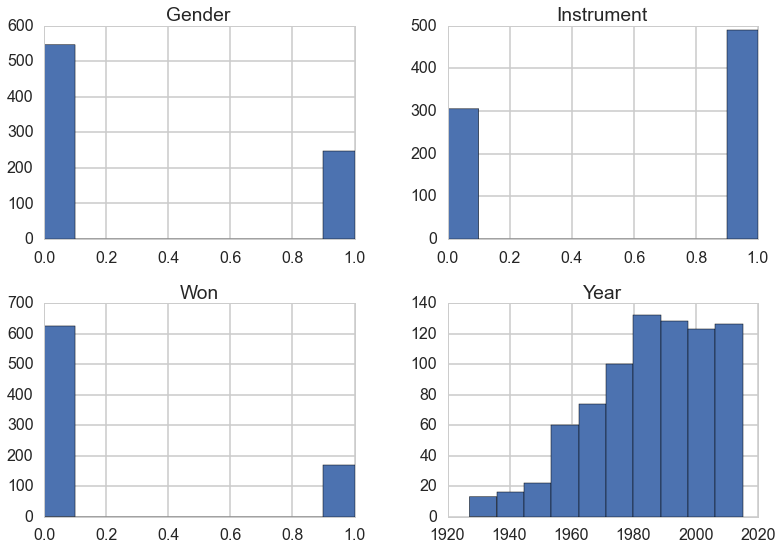

In [21]:
# in order to get a sense of the data, we can histogram the different columns
df.hist()
plt.show()

As expected, the number of female winners is only about about 30% of the total. There are more pianist winners - although this just has to do with the fact that our dataset includes more piano competitions. Predictably, most contestants don't win top prize (by definition) - this is shown in the 3rd plot. The last plot simply shows that the number of competitions has been increasing over the years.

We now create indicator columns for the Region information (as done in the homework). The get_dummies function in pandas can be used for this.

In [22]:
df_indicators = pd.get_dummies(df['Region'], prefix='Region')
df_filtered = df[['Won','Gender']].join(df_indicators)
del df_filtered['Region_Other']
df_filtered['Int'] = 1.0
df_filtered.head()

,Won,Gender,Region_Asia,Region_Europe,Region_USA/Canada,Int
0,1,0,0,1,0,1
1,0,0,0,1,0,1
2,0,1,0,1,0,1
3,0,0,0,1,0,1
4,1,0,0,1,0,1


The dataframe above had the column Region_Other removed since the information in this column can be ascertained from the other three region columns and is redundant. We have also added an intercept column and set it to 1 everywhere, as is common to do in regression.

We now split the data into training and test sets.

In [23]:
from sklearn.cross_validation import train_test_split

df_train, df_test = train_test_split(df_filtered, test_size = 0.2)

In order to train the classifier, we further split the training set and perform a 3-fold cross validation so that our result is unbiased. To do this, we create a dataframe all_combinations which includes all possible combinations of contestants for the features we choose to regress on (i. e. gender, region, etc). We then create two functions: test_values will take a dataframe and calculate the fraction of winners belonging to each category of contestant. The function calculate_error will then use the predicted probabilities from the training dataframe, compare them to the output of test_values and calculate the mean square error.

In [24]:
def test_values(df):
    test_grouped = df.groupby(['Gender','Region_Asia','Region_Europe','Region_USA/Canada'])
    winprob = test_grouped['Won'].mean()
    winprob_err = test_grouped['Won'].std()/np.sqrt(test_grouped['Won'].count()) # standard errors of mean
    
    test_m = []
    test_m_err = []
    test_f = []
    test_f_err = []
    for key in sorted(keys, reverse = True):
        if key[0] == 1:
            try:
                test_f.append(winprob[key])
                test_f_err.append(winprob_err[key])
            except:
                test_f.append(0)
                test_f_err.append(0)
        else:
            try:
                test_m.append(winprob[key])
                test_m_err.append(winprob[key])
            except:
                test_m.append(0)
                test_m_err.append(0)
    
    return test_f, test_f_err, test_m, test_m_err

def calculate_error(pred_m,pred_f,test_m,test_f):
    pred = pred_m + pred_f
    test = test_m + test_f
    test = test/np.sum(test)
    
    squares = []
    for i in range(len(pred)):
        squares.append((pred[i]-test[i])**2)
    err = np.sum(squares)/len(pred)
    return err


# create a list of lists containing all combinations of regions, instruments and genders
all_combinations = [];
for i in range(4):
    for j in range(2):
            all_combinations.append([i,j])

# turn list into dataframe
all_combinations = pd.DataFrame(all_combinations, columns = ["Region","Gender"])

# as before make indicator dataframe out of Region column
combination_indicators = pd.get_dummies(all_combinations['Region'], prefix='Region')
combination_indicators.columns = ['Region_Asia', 'Region_Europe', 'Region_USA/Canada', 'Region_Other']

# join the combinations dataframe to the indicator dataframe
all_combinations = all_combinations.join(combination_indicators)

# remove the Region column, since this was only needed to make the indicators
del all_combinations['Region']

# remove Region_Other since this puts in reduntant information
del all_combinations['Region_Other']

# add intercept column, as before
all_combinations['Int'] = 1.0

keys = [tuple(x) for x in all_combinations[all_combinations.columns[:-1]].values] # get rows of all_combinations

k = 3 # k-fold cross-validation
splitarray = np.array_split(df_train,k) # split dataframe into multiple arrays

score = []
for i in range(k):
    train = []
    for j in range(k):
        if i == j:
            validdf = splitarray[j]
        else:
            train.append(splitarray[j])
    traindf = pd.concat(train)
    
    logit = sm.Logit(traindf['Won'], traindf[traindf.columns[1:]])
    regr = logit.fit()

    pred = regr.predict(all_combinations)/np.sum(regr.predict(all_combinations))
    pred_m = [pred[0],pred[2],pred[4],pred[6]]
    pred_f = [pred[1],pred[3],pred[5],pred[7]]

    valid_f, valid_f_err, valid_m, valid_m_err = test_values(validdf) 

    score.append(calculate_error(pred_m,pred_f,valid_m,valid_f))
    
print "Average error: ", np.mean(score)

Optimization terminated successfully.
         Current function value: 0.507415
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.500848
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.490598
         Iterations 6
Average error:  0.00775971930841


We explored several models (ones in which different features are included or excluded) and found that the best classification occurs when the Years and Instruments features are excluded. This tuning of the model was the purpose of doing a cross-validation. Now, that we have our model, we can train the classifier on the entire original training set and test on the test set. This is done below:

In [25]:
# now perform logistic regression with statsmodels
logit = sm.Logit(df_train['Won'], df_train[df_train.columns[1:]])
regr = logit.fit()

Optimization terminated successfully.
         Current function value: 0.500589
         Iterations 6


In [26]:
# we can print out the summary of the regression results
print regr.summary()

                           Logit Regression Results                           
Dep. Variable:                    Won   No. Observations:                  635
Model:                          Logit   Df Residuals:                      630
Method:                           MLE   Df Model:                            4
Date:                Thu, 10 Dec 2015   Pseudo R-squ.:                 0.02462
Time:                        10:55:24   Log-Likelihood:                -317.87
converged:                       True   LL-Null:                       -325.90
                                        LLR p-value:                  0.002956
                        coef    std err          z      P>|z|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Gender               -0.2876      0.234     -1.228      0.219        -0.746     0.171
Region_Asia          -0.6892      0.427     -1.613      0.107        -1.526     0.148
Region_Europe        -0.

We can see that Gender has a negative coefficient, suggesting that being female negatively impacts your chances of winning. The region coefficients have large error bars although the Europe coefficient is more positive, suggesting that being European also has an advantage. As explained in the logistic regression discussion at http://blog.yhathq.com/posts/logistic-regression-and-python.html, we can exponentiate the coefficients to get the odds ratio of the parameters.

In [27]:
# get the odds ratio
print np.exp(regr.params)

Gender               0.750099
Region_Asia          0.501995
Region_Europe        0.882897
Region_USA/Canada    0.325779
Int                  0.403514
dtype: float64


We can see that the Gender odds ratio is 0.75, showing that that if you are male you are more likely to win a competition as if you were female (all other things being equal). 

The Region odds ratios are harder to interpret so we make a plot to illustrate the effect. We first make predictions based on the logistic regression model.

In [28]:
all_combinations['prediction'] = regr.predict(all_combinations)/np.sum(regr.predict(all_combinations))

all_combinations.head(16)

,Gender,Region_Asia,Region_Europe,Region_USA/Canada,Int,prediction
0,0,1,0,0,1,0.112318
1,1,1,0,0,1,0.087952
2,0,0,1,0,1,0.175156
3,1,0,1,0,1,0.140614
4,0,0,0,1,1,0.077472
5,1,0,0,1,1,0.059849
6,0,0,0,0,1,0.191708
7,1,0,0,0,1,0.154931


We can also get these the actual values from the test set. This is accomplished with the function test_values, below:

In [29]:
test_f, test_f_err, test_m, test_m_err = test_values(df_test) # get test values for all categories of contestants

We now plot the predicted probabilities vs. the actual probabilities (from the test set)

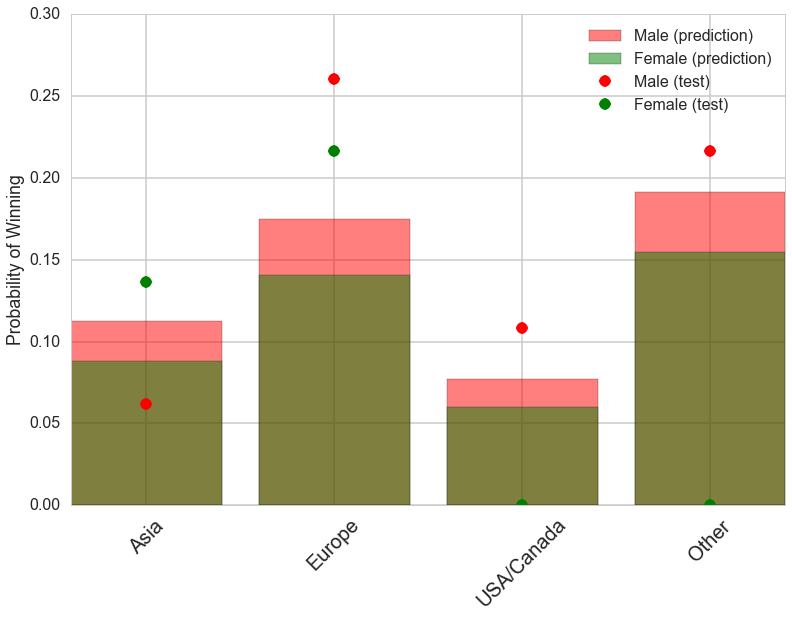

In [30]:
pred_m = [all_combinations['prediction'][0],all_combinations['prediction'][2],all_combinations['prediction'][4],all_combinations['prediction'][6]]
pred_f = [all_combinations['prediction'][1],all_combinations['prediction'][3],all_combinations['prediction'][5],all_combinations['prediction'][7]]

fig = plt.figure()
ax = fig.add_subplot(111)

r1 = ax.bar(range(4), pred_m, width = 0.8, align = 'center', color = 'r', alpha = 0.5)
r2 = ax.bar(range(4), pred_f, width = 0.8, align = 'center', color = 'g', alpha = 0.5)
xTickMarks = ['Asia','Europe','USA/Canada','Other'] 
ax.set_xticks([0,1,2,3])
ax.set_ylabel('Probability of Winning')
xtickNames = ax.set_xticklabels(xTickMarks)
plt.setp(xtickNames, rotation=45, fontsize=20)

r4 = plt.plot(range(4), test_f/np.sum(test_m + test_f), 'go')
r3 = plt.plot(range(4), test_m/np.sum(test_m + test_f), 'ro')
ax.legend((r1[0], r2[0], r3[0], r4[0]), ('Male (prediction)', 'Female (prediction)', 'Male (test)', 'Female (test)'))

plt.show()

To calculate the error on the prediction, we first consider the baseline model. Here we assume that we make the most naive prediction: namely that each of the 8 categories of contestants are equally likely and receive 0.125 probability.

In [31]:
baseline_m = baseline_f = [0.125, 0.125, 0.125, 0.125]

def calculate_error(pred_m,pred_f,test_m,test_f):
    pred = pred_m + pred_f
    test = test_m + test_f
    test = test/np.sum(test)
    
    squares = []
    for i in range(len(pred)):
        squares.append((pred[i]-test[i])**2)
    err = np.sum(squares)/len(pred)
    return err

baseline_score = calculate_error(baseline_m,baseline_f,valid_m,valid_f)
logistic_score = calculate_error(pred_m,pred_f,test_m,test_f)
print "Baseline error: ", baseline_score
print "Logistic Regression error: ", logistic_score

Baseline error:  0.0151993056492
Logistic Regression error:  0.00588935109014


# IV: Discussion
We can see that the Logistic Regression classifier does quite a bit better than chance. Additionally, from the plot above it's evident that our model captures nicely the differences in probabilities by gender and region. In particular, we can see that on average females have a lower chance of winning than males. Also, Asians tend to do more poorly than Europeans, in good agreement with our heuristic arguments based on historical trends above.

One interesting and unexpected aspect is that the "Other" region category does quite well. What this implies is that musicians in this category (which come mostly from South America and the Middle East) tend to rarely get prizes in competitions (although this may simply be due to fewer of these candidates entering the competitions), but when they do, they often win the top prize. 

Additionally, it seems that in addition to Asians having a relatively low probability of winning, candidates from the USA/Canada region also do poorly. A cursury look at the data suggests a possible explanation. A very large fraction of candidates with USA/Canada affiliation have Asian names. This may suggest that the bias is based on race rather than national origin and American candidates of Asian descent experience just as much bias as those directly from Asia.

# IV: Summary

We began by exploring the historican trends in who tends to be among the prizewinners of music competitions and found that generally men outnumber women roughly 2:1. However, we also found that over the years, the number of female prizewinners has increased in violin competitions while the number of women has stayed roughly constant in piano competitions.

We then considered the role of bias in determining the top prize winners by using the population distribution of contestants among the prizewinners as a proxy for the general population that took part in the competitions. Although this is likely an imperfect assumption, it nevertheless demonstrated that females and contestants of certain national origins do significantly worse than chance, giving some evidence of potential bias.

Specifically, we found that while the odds ratio of being female over being male (all other things being equal) is significantly lower than 1, the ratio is higher than 0.5, suggesting that at least some of the effect of males outnumbering females 2:1 can be explained by more women entering competitions over the years. 

On the other hand, our predictions show that contestants of European origin as well as those classified as "Other" (typically South American or Middle Eastern) do almost twice as well as contestants of Asian or American (including Canada) origin. 

These observations give evidence to the anecdotal evidence of bias described in the articles at the top of this notebook. They substantiate some of these claims while revealing other unexpected features.